### 使用高层API：tf.contrib.learn 来构建一个分类神经网络

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np

In [ ]:
# 定义数据集的路径
IRIS_TRAINING = "iris_training.csv"
IRIS_TEST = "iris_test.csv"

# 加载数据集
# # 加载训练集
training_set = tf.contrib.learn.datasets.base.load_csv_with_header(
    filename=IRIS_TRAINING,
    target_dtype=np.int,
    features_dtype=np.float32)

# # 加载测试集  
test_set = tf.contrib.learn.datasets.base.load_csv_with_header(
    filename=IRIS_TEST,
    target_dtype=np.int,
    features_dtype=np.float32)


tf.contrib.learn提供了多种多样的预定义模型，叫做Estimators（估计器），这些Estimator在你拟运行训练与评估模型的操作的时候可以实现开箱即用，也就是说，当你要使用某个模型的时候，不再需要去写他的内部逻辑，直接调用这个模型的接口，用一句代码搞定即可。

In [ ]:
# Specify that all features have real-value data
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=4)]

# Build 3 layer DNN with 10, 20, 10 units respectively.
classifier = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                            hidden_units=[10, 20, 10],
                                            n_classes=3,
                                            model_dir="/tmp/iris_model")

以上代码首先定义了模型的特征列，并且指定了特征数据的数据类型。在上一节中我们看到所有的特征都是连续型变量，所以tf.contrib.layers.real_valued_column这个函数被用来构建特征列。另外，我们的数据集中有4个特征，故传入参数dimension=4.

接着，以上代码使用了tf.contrib.learn.DNNClassifier这个函数来直接构建DNN模型。（记得前面两个笔记，无论是讲简单的分类模型softmax regression还是稍微复杂的卷积神经网络，都是自己一层一层地去写模型的逻辑结构，相当繁琐，看！高级的API已经为我们封装好了这些模型，我们只需要直接调用方法就行） 
 DNNClassifier这个方法需要传入4个参数： 
 （1）feature_columns=feature_columns，将刚刚预先定义好的特征列传给参数feature_columns。 
 （2）hidden_units=[10, 20, 10]，设置隐藏层中的神经元个数，这里表示共有3个隐藏层，依次的神经元个数为10,20,10。 
 （3）n_classes=3，设置目标分类的个数，这个是3类，分成3种鸢尾花。 
 （4）model_dir=/tmp/iris_model，这是保存模型训练过程中的checkpoint检查点的数据的路径

In [ ]:
# Fit model
classifier.fit(x=training_set.data, y=training_set.target, steps=2000)
也可以分开迭代，上行等同于：
classifier.fit(x=training_set.data, y=training_set.target, steps=1000)
classifier.fit(x=training_set.data, y=training_set.target, steps=1000)

评估模型的时候使用的是测试集，与.fit()方法相似，评估模型调用.evaluate()方法，并且将测试集的特征传入给x，测试集的标签传入给y，并且指定计算的是accuracy。

In [ ]:
accuracy_score = classifier.evaluate(x=test_set.data, y=test_set.target)["accuracy"]
print('Accuracy: {0:f}'.format(accuracy_score))

In [ ]:
# 根据上述的模型预测新的样本
# 新的两个样本
new_samples = np.array(
    [[6.4, 3.2, 4.5, 1.5], [5.8, 3.1, 5.0, 1.7]], dtype=float)

# 预测  
y = list(classifier.predict(new_samples, as_iterable=True))

# 打印
print('Predictions: {}'.format(str(y)))

### Tensorflow高级API的进阶--利用tf.contrib.learn建立输入函数 

以下是一个input_fn函数的基本结构：

In [2]:
def my_input_fn():

    # Preprocess your data here...(首先预处理你的数据）

    # ...then return 1) a mapping of feature columns to Tensors with
    # the corresponding feature data, and 2) a Tensor containing labels
    # 然后返回新的特征数据与标签数据（都是以tensor的形式）
    return feature_cols, labels

输入函数的主体包括一个特定的预处理输入数据的逻辑，比如去除一些脏数据，弥补缺失数据，归一化等等。

输入函数的返回是两个部分： 
 （1）处理后的特征：feature_cols，格式是一个map，key是特征的名称，value是tensor形式的对应的特征列数据 
 （2）标签数据：labels，一个包含标签数据的tensor

如果你的特征/标签是存储在pandas的dataframe中或者numpy的array中的话，你就需要在返回特征与标签的时候将它们转换成tensor形式

In [3]:
#对于连续型数据，你可以使用tf.constant创建一个tensor:
feature_column_data = [1, 2.4, 0, 9.9, 3, 120]
feature_tensor = tf.constant(feature_column_data)

In [4]:
#对于稀疏型数据，类别下数据，你可以使用tf.SparseTensor来创建tensor:
sparse_tensor = tf.SparseTensor(indices=[[0,1], [2,4]],
                                values=[6, 0.5],
                                dense_shape=[3, 5])

#### 如何将input_fn数据传给模型？

In [ ]:
#在.fit()操作中有一个参数：input_fn，只要将我们定义好的输入函数传给这个参数即可：
classifier.fit(input_fn=my_input_fn, steps=2000)

In [ ]:
#但是，极其注意的是绝不能直接这样做：
classifier.fit(input_fn=my_input_fn(training_set), steps=2000)

如果你想直接传参数给输入函数，可以选择令爱几个方法： 
 （1）再写一个封装函数如下：
    classifier.fit(input_fn=functools.partial(my_input_function,
                                          data_set=training_set), steps=2000)
 （2）使用Python’s functools.partial方法：
    classifier.fit(input_fn=functools.partial(my_input_function,
                                          data_set=training_set), steps=2000)
 （3）在lambda中调用输入函数，然后将参数传入input_fn中：
    classifier.fit(input_fn=lambda: my_input_fn(training_set), steps=2000)
建议使用第三种方法

#### 加载数据

首先导入需要的库（包括pandas, tensorflow),并且设置logging verbosity为INFO，这样就可以获取到更多的日志信息了。

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

import pandas as pd
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

定义一个变量COLUMNS，将所有的特征名称与类别标签名称存储成list并赋值给他。 为了区分特征名称与标签名称，同时也将它们分别存储一个变量

In [7]:
COLUMNS = ["crim", "zn", "indus", "nox", "rm", "age",
           "dis", "tax", "ptratio", "medv"]
FEATURES = ["crim", "zn", "indus", "nox", "rm",
            "age", "dis", "tax", "ptratio"]
LABEL = "medv"

然后，将三份数据文件都用pandas.read_csv载入： 
       第一个参数是数据文件的路径，第二个参数是是否需要取出前后空值，第三个参数是去除的行数，第四个参数是列名

In [ ]:
training_set = pd.read_csv("boston_train.csv", skipinitialspace=True,
                           skiprows=1, names=COLUMNS)

test_set = pd.read_csv("boston_test.csv", skipinitialspace=True,
                       skiprows=1, names=COLUMNS)

prediction_set = pd.read_csv("boston_predict.csv", skipinitialspace=True,
                             skiprows=1, names=COLUMNS)

#### 定义特征列并且创建回归模型

现在创建一组FeatureColumn作为输入数据，正式指定哪些特征需要被用来训练。在我们的房价预测特征中所有数据都是连续型的值，因此你可以直接使用tf.contrib.layers.real_valued_column()来创建FeatureColumn

In [ ]:
feature_cols = [tf.contrib.layers.real_valued_column(k)
                  for k in FEATURES]

接着我们来调用DNNRegressor函数实例化一个神经网络回归模型。 
 这里需要提供3个参数： 
 feature_columns：一组刚刚定义的特征列 
 hidden_units：每层隐藏层的神经网络个数 
 model_dir：模型保存的路径

In [ ]:
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
                                          hidden_units=[10, 10],
                                          model_dir="/tmp/boston_model")

#### 构建输入函数input_fn

这里我们构建一个输入函数去预处理数据，处理的内容比较简单，只是将用pandas读进来的dataframe形式的数据转换成tensor.

In [8]:
def input_fn(data_set):
  feature_cols = {k: tf.constant(data_set[k].values)
                  for k in FEATURES}
  labels = tf.constant(data_set[LABEL].values)
  return feature_cols, labels

In [ ]:
#训练模型
regressor.fit(input_fn=lambda: input_fn(training_set), steps=5000)
#评估模型
ev = regressor.evaluate(input_fn=lambda: input_fn(test_set), steps=1)
#提取损失并打印：
loss_score = ev["loss"]
print("Loss: {0:f}".format(loss_score))
#使用模型做预测
y = regressor.predict(input_fn=lambda: input_fn(prediction_set))

# .predict() returns an iterator; convert to a list and print predictions

predictions = list(itertools.islice(y, 6)) #取出y的前六个
print ("Predictions: {}".format(str(predictions)))

      # islice('ABCDEFG', 2) --> A B
      # islice('ABCDEFG', 2, 4) --> C D
      # islice('ABCDEFG', 2, None) --> C D E F G
      # islice('ABCDEFG', 0, None, 2) --> A C E G

### TensorFlow 高级 API tflearn

In [ ]:
from __future__ import division, print_function, absolute_import  
  
import tflearn  
from tflearn.layers.core import input_data, dropout, fully_connected  
from tflearn.layers.conv import conv_2d, max_pool_2d  
from tflearn.layers.normalization import local_response_normalization  
from tflearn.layers.estimator import regression  
#加载大名顶顶的mnist数据集（http://yann.lecun.com/exdb/mnist/）  
import tflearn.datasets.mnist as mnist  
X, Y, testX, testY = mnist.load_data(one_hot=True)  
X = X.reshape([-1, 28, 28, 1])  
testX = testX.reshape([-1, 28, 28, 1])  
  
network = input_data(shape=[None, 28, 28, 1], name='input')  
# CNN中的卷积操作,下面会有详细解释  
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")  
# 最大池化操作  
network = max_pool_2d(network, 2)  
# 局部响应归一化操作  
network = local_response_normalization(network)  
network = conv_2d(network, 64, 3, activation='relu', regularizer="L2")  
network = max_pool_2d(network, 2)  
network = local_response_normalization(network)  
# 全连接操作  
network = fully_connected(network, 128, activation='tanh')  
# dropout操作  
network = dropout(network, 0.8)  
network = fully_connected(network, 256, activation='tanh')  
network = dropout(network, 0.8)  
network = fully_connected(network, 10, activation='softmax')  
# 回归操作  
network = regression(network, optimizer='adam', learning_rate=0.01,  
                     loss='categorical_crossentropy', name='target')  
  
# Training  
# DNN操作，构建深度神经网络  
model = tflearn.DNN(network, tensorboard_verbose=0)  
model.fit({'input': X}, {'target': Y}, n_epoch=20,  
           validation_set=({'input': testX}, {'target': testY}),  
           snapshot_step=100, show_metric=True, run_id='convnet_mnist')  

### 利用 TensorFlow 高级 API Keras 实现 MLP，CNN，LSTM 

TensorFlow 代码长，不好读，不好理解，这可能是很多初学者的痛。在一些开发者努力下基于 TF 构建了更高级的 API，无需再用冗长难记的底层 API 构建模型。在众多高级 API 中，Keras 和 TFLearn 较为流行。

In [ ]:
# 加载 Keras 模型相关的 Python 模块

from keras.models import Sequential

from keras.layers.core import Dense, Dropout, Activation

from keras.optimizers import RMSprop




# 构建 MLP 网络

model = Sequential()    

model.add(Dense(512, input_shape=(784,))) # 全连接层

model.add(Activation('relu')) # ReLU

model.add(Dropout(0.2)) # Dropout

model.add(Dense(512)) # 全连接层

model.add(Activation('relu')) # ReLU

model.add(Dropout(0.2)) # Dropout

model.add(Dense(10)) # 分类层

model.add(Activation('softmax')) # Softmax

model.summary() # 打印模型

model.compile(loss='categorical_crossentropy',

              optimizer=RMSprop(),

              metrics=['accuracy']) # 生成模型


In [ ]:
#下面是一个 CNN 例子（mnist_cnn.py）：


# 加载 Keras 模型相关的 Python 模块

from keras.models import Sequential

from keras.layers import Dense, Dropout, Activation, Flatten

from keras.layers import Convolution2D, MaxPooling2D

# 构建 CNN 网络

model = Sequential()

model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],

                        border_mode='valid',

                        input_shape=input_shape)) # 卷积层

model.add(Activation('relu')) # ReLU

model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1])) # 卷积层

model.add(Activation('relu')) # ReLU

model.add(MaxPooling2D(pool_size=pool_size)) # Maxpooling

model.add(Dropout(0.25)) # Dropout

model.add(Flatten()) # 将响应转换为一维向量

model.add(Dense(128)) # 全连接层

model.add(Activation('relu')) # ReLU

model.add(Dropout(0.5)) # Dropout

model.add(Dense(nb_classes)) # 分类层

model.add(Activation('softmax')) # Softmax

model.compile(loss='categorical_crossentropy',

              optimizer='adadelta',

              metrics=['accuracy']) # 生成模型


In [ ]:
#接着看一个 LSTM 例子（imdb_lstm.py），完成 IMDB 上句子分类任务：



# 加载 Keras 模型相关的 Python 模块

from keras.models import Sequential

from keras.layers import Dense, Activation, Embedding

from keras.layers import LSTM

# 构建 LSTM 模型

model = Sequential()

model.add(Embedding(max_features, 128, dropout=0.2)) # 词嵌入

model.add(LSTM(128, dropout_W=0.2, dropout_U=0.2))  # LSTM 层

model.add(Dense(1))    # 二分类层

model.add(Activation('sigmoid')) # Sigmoid 

model.summary()  # 打印模型


model.compile(loss='binary_crossentropy',

              optimizer='adam',

              metrics=['accuracy']) # 生成模型


In [ ]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


## tensorflow基础 

In [1]:
import tensorflow as tf
v = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
sess=tf.Session()
print(sess.run(tf.reduce_mean(v)))

3.5


tf.reduce_mean(x) ==> 2.5 #如果不指定第二个参数，那么就在所有的元素中取平均值
tf.reduce_mean(x, 0) ==> [2.,  3.] #指定第二个参数为0，则第一维的元素取平均值，即每一列求平均值
tf.reduce_mean(x, 1) ==> [1.5,  3.5] #指定第二个参数为1，则第二维的元素取平均值，即每一行求平均值

tf.add_to_collection：把变量放入一个集合，把很多变量变成一个列表
tf.get_collection：从一个结合中取出全部变量，是一个列表
tf.add_n：把一个列表的东西都依次加起来

In [9]:
import numpy as np
xx, yy = np.mgrid[-1.2:1.2:.01, -0.2:2.2:.01]
print (xx)
print (yy)
print (len(xx))
print (len(yy[0]))

[[-1.2  -1.2  -1.2  ..., -1.2  -1.2  -1.2 ]
 [-1.19 -1.19 -1.19 ..., -1.19 -1.19 -1.19]
 [-1.18 -1.18 -1.18 ..., -1.18 -1.18 -1.18]
 ..., 
 [ 1.17  1.17  1.17 ...,  1.17  1.17  1.17]
 [ 1.18  1.18  1.18 ...,  1.18  1.18  1.18]
 [ 1.19  1.19  1.19 ...,  1.19  1.19  1.19]]
[[-0.2  -0.19 -0.18 ...,  2.18  2.19  2.2 ]
 [-0.2  -0.19 -0.18 ...,  2.18  2.19  2.2 ]
 [-0.2  -0.19 -0.18 ...,  2.18  2.19  2.2 ]
 ..., 
 [-0.2  -0.19 -0.18 ...,  2.18  2.19  2.2 ]
 [-0.2  -0.19 -0.18 ...,  2.18  2.19  2.2 ]
 [-0.2  -0.19 -0.18 ...,  2.18  2.19  2.2 ]]
240
241


In [7]:
print (xx.ravel())

[-1.2  -1.2  -1.2  ...,  1.19  1.19  1.19]


In [5]:
grid = np.c_[xx.ravel(), yy.ravel()]
print (grid)
print (len(grid))

[[-1.2  -0.2 ]
 [-1.2  -0.19]
 [-1.2  -0.18]
 ..., 
 [ 1.19  2.18]
 [ 1.19  2.19]
 [ 1.19  2.2 ]]
57840


In [ ]:
#滑动平均模型
import tensorflow as tf

# 1. 定义变量及滑动平均类
v1 = tf.Variable(0, dtype=tf.float32)
step = tf.Variable(0, trainable=False)
ema = tf.train.ExponentialMovingAverage(0.99, step)
maintain_averages_op = ema.apply([v1])

# 2. 查看不同迭代中变量取值的变化
with tf.Session() as sess:
    # 初始化
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    print(sess.run([v1, ema.average(v1)]))

    # 更新变量v1的取值
    sess.run(tf.assign(v1, 5))
    sess.run(maintain_averages_op)
    print(sess.run([v1, ema.average(v1)]))

    # 更新step和v1的取值
    sess.run(tf.assign(step, 10000))
    sess.run(tf.assign(v1, 10))
    sess.run(maintain_averages_op)
    print(sess.run([v1, ema.average(v1)]))

    # 更新一次v1的滑动平均值
    sess.run(maintain_averages_op)
    print(sess.run([v1, ema.average(v1)]))
'''
[0.0, 0.0]
[5.0, 4.5] # decay=min(0.99, 1/10)=0.1, v1=0.1*0+0.9*5=4.5 
[10.0, 4.5549998]  # decay=min(0.99,(1+10000)/(10+10000))=0.99, v1=0.99*4.5+0.01*10=4.555  
[10.0, 4.6094499]
'''

tf.train.ExponentialMovingAverage(decay, steps)
tf.train.ExponentialMovingAverage这个函数用于更新参数，就是采用滑动平均的方法更新参数。这个函数初始化需要提供一个衰减速率（decay），用于控制模型的更新速度。这个函数还会维护一个影子变量（也就是更新参数后的参数值），这个影子变量的初始值就是这个变量的初始值，影子变量值的更新方式如下：
shadow_variable = decay * shadow_variable + (1-decay) * variable
shadow_variable是影子变量，variable表示待更新的变量，也就是变量被赋予的值，decay为衰减速率。decay一般设为接近于1的数（0.99,0.999）。decay越大模型越稳定，因为decay越大，参数更新的速度就越慢，趋于稳定。
tf.train.ExponentialMovingAverage这个函数还提供了自己动更新decay的计算方式：
decay= min（decay，（1+steps）/（10+steps））
steps是迭代的次数，可以自己设定。

### tensorflow全模型(正则化+衰减的学习率+滑动平均)

In [11]:
# 《TensorFlow实战Google深度学习框架》05 minist数字识别问题
# win10 Tensorflow1.0.1 python3.5.3
# CUDA v8.0 cudnn-8.0-windows10-x64-v5.1
# filename:ts05.02.py # TensorFlow训练神经网络--全模型

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# 1.设置输入和输出节点的个数,配置神经网络的参数
INPUT_NODE = 784  # 输入节点
OUTPUT_NODE = 10  # 输出节点
LAYER1_NODE = 500  # 隐藏层数

BATCH_SIZE = 100  # 每次batch打包的样本个数

# 模型相关的参数
LEARNING_RATE_BASE = 0.8
LEARNING_RATE_DECAY = 0.99
REGULARAZTION_RATE = 0.0001
TRAINING_STEPS = 5000
MOVING_AVERAGE_DECAY = 0.99

# 2. 定义辅助函数来计算前向传播结果，使用ReLU做为激活函数。
def inference(input_tensor, avg_class, weights1, biases1, weights2, biases2):
    # 不使用滑动平均类
    if avg_class == None:
        layer1 = tf.nn.relu(tf.matmul(input_tensor, weights1) + biases1)
        return tf.matmul(layer1, weights2) + biases2
    else:
        # 使用滑动平均类
        layer1 = tf.nn.relu(tf.matmul(input_tensor, avg_class.average(weights1)) + avg_class.average(biases1))
        return tf.matmul(layer1, avg_class.average(weights2)) + avg_class.average(biases2)

# 3. 定义训练过程
def train(mnist):
    x = tf.placeholder(tf.float32, [None, INPUT_NODE], name='x-input')
    y_ = tf.placeholder(tf.float32, [None, OUTPUT_NODE], name='y-input')
    # 生成隐藏层的参数。
    weights1 = tf.Variable(tf.truncated_normal([INPUT_NODE, LAYER1_NODE], stddev=0.1))
    biases1 = tf.Variable(tf.constant(0.1, shape=[LAYER1_NODE]))
    # 生成输出层的参数。
    weights2 = tf.Variable(tf.truncated_normal([LAYER1_NODE, OUTPUT_NODE], stddev=0.1))
    biases2 = tf.Variable(tf.constant(0.1, shape=[OUTPUT_NODE]))

    # 计算不含滑动平均类的前向传播结果
    y = inference(x, None, weights1, biases1, weights2, biases2)

    # 定义训练轮数及相关的滑动平均类
    global_step = tf.Variable(0, trainable=False)
    variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, global_step)
    variables_averages_op = variable_averages.apply(tf.trainable_variables())
    average_y = inference(x, variable_averages, weights1, biases1, weights2, biases2)

    # 计算交叉熵及其平均值
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y, labels=tf.argmax(y_, 1))
    cross_entropy_mean = tf.reduce_mean(cross_entropy)

    # 损失函数的计算
    regularizer = tf.contrib.layers.l2_regularizer(REGULARAZTION_RATE)
    regularaztion = regularizer(weights1) + regularizer(weights2)
    loss = cross_entropy_mean + regularaztion

    # 设置指数衰减的学习率。
    learning_rate = tf.train.exponential_decay(
        LEARNING_RATE_BASE,
        global_step,
        mnist.train.num_examples / BATCH_SIZE,
        LEARNING_RATE_DECAY,
        staircase=True)

    # 优化损失函数
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # 反向传播更新参数和更新每一个参数的滑动平均值
    with tf.control_dependencies([train_step, variables_averages_op]):
        train_op = tf.no_op(name='train')

    # 计算正确率
    correct_prediction = tf.equal(tf.argmax(average_y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # 初始化回话并开始训练过程。
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        validate_feed = {x: mnist.validation.images, y_: mnist.validation.labels}
        test_feed = {x: mnist.test.images, y_: mnist.test.labels}

        # 循环的训练神经网络。
        for i in range(TRAINING_STEPS):
            if i % 1000 == 0:
                validate_acc = sess.run(accuracy, feed_dict=validate_feed)
                print("After %d training step(s), validation accuracy using average model is %g " % (i, validate_acc))

            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            sess.run(train_op, feed_dict={x: xs, y_: ys})

        test_acc = sess.run(accuracy, feed_dict=test_feed)
        print(("After %d training step(s), test accuracy using average model is %g" % (TRAINING_STEPS, test_acc)))


# 4. 主程序入口，这里设定模型训练次数为5000次。
def main(argv=None):
    mnist = input_data.read_data_sets("../../../datasets/MNIST_data", one_hot=True)
    train(mnist)

if __name__=='__main__':
    main()

'''
Extracting ../../../datasets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ../../../datasets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../../../datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../../../datasets/MNIST_data\t10k-labels-idx1-ubyte.gz
After 0 training step(s), validation accuracy using average model is 0.1284 
After 1000 training step(s), validation accuracy using average model is 0.9764 
After 2000 training step(s), validation accuracy using average model is 0.9806 
After 3000 training step(s), validation accuracy using average model is 0.9818 
After 4000 training step(s), validation accuracy using average model is 0.9822 
After 5000 training step(s), test accuracy using average model is 0.9822
'''

Extracting ../../../datasets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ../../../datasets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../../../datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../../../datasets/MNIST_data\t10k-labels-idx1-ubyte.gz
After 0 training step(s), validation accuracy using average model is 0.107 
After 1000 training step(s), validation accuracy using average model is 0.9762 
After 2000 training step(s), validation accuracy using average model is 0.9798 
After 3000 training step(s), validation accuracy using average model is 0.983 
After 4000 training step(s), validation accuracy using average model is 0.9834 
After 5000 training step(s), test accuracy using average model is 0.9836


'\nExtracting ../../../datasets/MNIST_data\train-images-idx3-ubyte.gz\nExtracting ../../../datasets/MNIST_data\train-labels-idx1-ubyte.gz\nExtracting ../../../datasets/MNIST_data\t10k-images-idx3-ubyte.gz\nExtracting ../../../datasets/MNIST_data\t10k-labels-idx1-ubyte.gz\nAfter 0 training step(s), validation accuracy using average model is 0.1284 \nAfter 1000 training step(s), validation accuracy using average model is 0.9764 \nAfter 2000 training step(s), validation accuracy using average model is 0.9806 \nAfter 3000 training step(s), validation accuracy using average model is 0.9818 \nAfter 4000 training step(s), validation accuracy using average model is 0.9822 \nAfter 5000 training step(s), test accuracy using average model is 0.9822\n'

#### 变量管理

In [16]:
import tensorflow as tf
v1 = tf.get_variable("ven", [1])
print(v1.name) # ven:0


ven:0


In [19]:
with tf.variable_scope("foo"):
    v1 = tf.get_variable("ven3", [1])
with tf.variable_scope("foo",reuse=True):
    v2 = tf.get_variable("ven3", [1])
print(v2.name) # foo/v:0


foo/ven3:0


In [21]:
v4 = tf.get_variable("v1", [1])
print(v4.name) # v1:0

v1:0


In [22]:
#  我们可以通过变量的名称来获取变量
with tf.variable_scope("",reuse=True):
    v5 = tf.get_variable("foo/ven3", [1])
    print(v5 == v2) # True
    v6 = tf.get_variable("v1", [1])
    print(v6 == v4) # True

True
True


### ckpt文件保存方法

In [3]:
import tensorflow as tf

# 1. 保存计算两个变量和的模型
v1 = tf.Variable(tf.constant(1.0, shape=[1]), name = "v1")
v2 = tf.Variable(tf.constant(2.0, shape=[1]), name = "v2")
result = v1 + v2

init_op = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init_op)
    # 需要在本python脚本文件下存在Saved_model目录
    # 否则提示错误 ValueError: Parent directory of Saved_model/model.ckpt doesn't exist, can't save.
    saver.save(sess, "D:/python_code/model/Saved_model/model.ckpt")

# 2. 加载保存了两个变量和的模型
with tf.Session() as sess:
    saver.restore(sess, "D:/python_code/model/Saved_model/model.ckpt")
    print(sess.run(result)) # [3.]

# 3. 直接加载持久化的图
saver = tf.train.import_meta_graph("D:/python_code/model/Saved_model/model.ckpt.meta")
with tf.Session() as sess:
    saver.restore(sess, "D:/python_code/model/Saved_model/model.ckpt")
    print(sess.run(tf.get_default_graph().get_tensor_by_name("add:0"))) # [3.]

# 4. 变量重命名
v1 = tf.Variable(tf.constant(1.0, shape=[1]), name = "other-v1")
v2 = tf.Variable(tf.constant(2.0, shape=[1]), name = "other-v2")
saver = tf.train.Saver({"v1": v1, "v2": v2})

INFO:tensorflow:Restoring parameters from D:/python_code/model/Saved_model/model.ckpt
[ 3.]
INFO:tensorflow:Restoring parameters from D:/python_code/model/Saved_model/model.ckpt
[ 3.]


#### 滑动平均类的保存

In [ ]:
import tensorflow as tf

# 1. 使用滑动平均
v = tf.Variable(0, dtype=tf.float32, name="v")
for variables in tf.global_variables():
    print(variables.name)
'''
v:0
'''
ema = tf.train.ExponentialMovingAverage(0.99)
maintain_averages_op = ema.apply(tf.global_variables())
for variables in tf.global_variables():
    print(variables.name)
'''
v:0
v/ExponentialMovingAverage:0
'''
# 2. 保存滑动平均模型
saver = tf.train.Saver()
with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    sess.run(tf.assign(v, 10))
    sess.run(maintain_averages_op)
    # 保存的时候会将v:0  v/ExponentialMovingAverage:0这两个变量都存下来。
    saver.save(sess, "Saved_model/model2.ckpt")
    print(sess.run([v, ema.average(v)]))
'''
[10.0, 0.099999905]
'''
# 3. 加载滑动平均模型
v = tf.Variable(0, dtype=tf.float32, name="v")

# 通过变量重命名将原来变量v的滑动平均值直接赋值给v。
saver = tf.train.Saver({"v/ExponentialMovingAverage": v})
with tf.Session() as sess:
    saver.restore(sess, "Saved_model/model2.ckpt")
    print(sess.run(v))
'''
0.0999999
'''

#### variables_to_restore函数

In [ ]:
import tensorflow as tf
v = tf.Variable(0, dtype=tf.float32, name="v")
ema = tf.train.ExponentialMovingAverage(0.99)
print(ema.variables_to_restore())
'''
{'v/ExponentialMovingAverage': <tensorflow.python.ops.variables.Variable object at 0x000001F0CFB260F0>}
'''
saver = tf.train.Saver({"v/ExponentialMovingAverage": v})
with tf.Session() as sess:
    saver.restore(sess, "Saved_model/model2.ckpt")
    print(sess.run(v))
'''
0.0999999
'''

### pb文件保存

In [ ]:
import tensorflow as tf

# 1. pb文件的保存方法
import tensorflow as tf
from tensorflow.python.framework import graph_util

v1 = tf.Variable(tf.constant(1.0, shape=[1]), name = "v1")
v2 = tf.Variable(tf.constant(2.0, shape=[1]), name = "v2")
result = v1 + v2

init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op)
    graph_def = tf.get_default_graph().as_graph_def()
    output_graph_def = graph_util.convert_variables_to_constants(sess, graph_def, ['add'])
    with tf.gfile.GFile("Saved_model/combined_model.pb", "wb") as f:
           f.write(output_graph_def.SerializeToString())

# 2. 加载pb文件
from tensorflow.python.platform import gfile

with tf.Session() as sess:
    model_filename = "Saved_model/combined_model.pb"

    with gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    result = tf.import_graph_def(graph_def, return_elements=["add:0"])
    print(sess.run(result)) # [array([ 3.], dtype=float32)]

### 加载ckpt 文件

In [ ]:
def evaluate(mnist):
    with tf.Graph().as_default() as g:
        x = tf.placeholder(tf.float32, [None, mnist_inference.INPUT_NODE], name='x-input')
        y_ = tf.placeholder(tf.float32, [None, mnist_inference.OUTPUT_NODE], name='y-input')
        validate_feed = {x: mnist.validation.images, y_: mnist.validation.labels}

        y = mnist_inference.inference(x, None)
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        variable_averages = tf.train.ExponentialMovingAverage(mnist_train.MOVING_AVERAGE_DECAY)
        variables_to_restore = variable_averages.variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)

        while True:
            with tf.Session() as sess:
                ckpt = tf.train.get_checkpoint_state(mnist_train.MODEL_SAVE_PATH)#mnist_train.MODEL_SAVE_PATH为训练函数中的模型保存地址
                if ckpt and ckpt.model_checkpoint_path:
                    saver.restore(sess, ckpt.model_checkpoint_path)
                    global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
                    accuracy_score = sess.run(accuracy, feed_dict=validate_feed)
                    print("After %s training step(s), validation accuracy = %g" % (global_step, accuracy_score))
                else:
                    print('No checkpoint file found')
                    return
            time.sleep(EVAL_INTERVAL_SECS)


### 迁移学习

In [ ]:
# 《TensorFlow实战Google深度学习框架》06 图像识别与卷积神经网络
# win10 Tensorflow1.0.1 python3.5.3
# CUDA v8.0 cudnn-8.0-windows10-x64-v5.1
# filename:ts06.03.py # 迁移学习

# 以下实验需要如下资源
# 源码及资源位置：git clone https://github.com/caicloud/tensorflow-tutorial.git
# 需要tensorflow-tutorial.git库中的flower_photos和inception_dec_2015
# tensorflow-tutorial\Deep_Learning_with_TensorFlow\datasets\flower_photos
# tensorflow-tutorial\Deep_Learning_with_TensorFlow\datasets\inception_dec_2015

import glob
import os.path
import random
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile

# 1. 模型和样本路径的设置
BOTTLENECK_TENSOR_SIZE = 2048
BOTTLENECK_TENSOR_NAME = 'pool_3/_reshape:0'
JPEG_DATA_TENSOR_NAME = 'DecodeJpeg/contents:0'


MODEL_DIR = '../../datasets/inception_dec_2015'
MODEL_FILE= 'tensorflow_inception_graph.pb'

CACHE_DIR = '../../datasets/bottleneck'
INPUT_DATA = '../../datasets/flower_photos'

VALIDATION_PERCENTAGE = 10
TEST_PERCENTAGE = 10

# 2. 神经网络参数的设置
LEARNING_RATE = 0.01
STEPS = 4000
BATCH = 100

# 3. 把样本中所有的图片列表并按训练、验证、测试数据分开
def create_image_lists(testing_percentage, validation_percentage):
    result = {}
    sub_dirs = [x[0] for x in os.walk(INPUT_DATA)]
    is_root_dir = True
    for sub_dir in sub_dirs:
        if is_root_dir:
            is_root_dir = False
            continue

        extensions = ['jpg', 'jpeg', 'JPG', 'JPEG']

        file_list = []
        dir_name = os.path.basename(sub_dir)
        for extension in extensions:
            file_glob = os.path.join(INPUT_DATA, dir_name, '*.' + extension)
            file_list.extend(glob.glob(file_glob))
        if not file_list: continue

        label_name = dir_name.lower()

        # 初始化
        training_images = []
        testing_images = []
        validation_images = []
        for file_name in file_list:
            base_name = os.path.basename(file_name)

            # 随机划分数据
            chance = np.random.randint(100)
            if chance < validation_percentage:
                validation_images.append(base_name)
            elif chance < (testing_percentage + validation_percentage):
                testing_images.append(base_name)
            else:
                training_images.append(base_name)

        result[label_name] = {
            'dir': dir_name,
            'training': training_images,
            'testing': testing_images,
            'validation': validation_images,
        }
    return result

# 4. 定义函数通过类别名称、所属数据集和图片编号获取一张图片的地址
def get_image_path(image_lists, image_dir, label_name, index, category):
    label_lists = image_lists[label_name]
    category_list = label_lists[category]
    mod_index = index % len(category_list)
    base_name = category_list[mod_index]
    sub_dir = label_lists['dir']
    full_path = os.path.join(image_dir, sub_dir, base_name)
    return full_path

# 5. 定义函数获取Inception-v3模型处理之后的特征向量的文件地址
def get_bottleneck_path(image_lists, label_name, index, category):
    return get_image_path(image_lists, CACHE_DIR, label_name, index, category) + '.txt'

# 6. 定义函数使用加载的训练好的Inception-v3模型处理一张图片，得到这个图片的特征向量
def run_bottleneck_on_image(sess, image_data, image_data_tensor, bottleneck_tensor):

    bottleneck_values = sess.run(bottleneck_tensor, {image_data_tensor: image_data})

    bottleneck_values = np.squeeze(bottleneck_values)
    return bottleneck_values

# 7. 定义函数会先试图寻找已经计算且保存下来的特征向量，如果找不到则先计算这个特征向量，然后保存到文件
def get_or_create_bottleneck(sess, image_lists, label_name, index, category, jpeg_data_tensor, bottleneck_tensor):
    label_lists = image_lists[label_name]
    sub_dir = label_lists['dir']
    sub_dir_path = os.path.join(CACHE_DIR, sub_dir)
    if not os.path.exists(sub_dir_path): os.makedirs(sub_dir_path)
    bottleneck_path = get_bottleneck_path(image_lists, label_name, index, category)
    if not os.path.exists(bottleneck_path):

        image_path = get_image_path(image_lists, INPUT_DATA, label_name, index, category)

        image_data = gfile.FastGFile(image_path, 'rb').read()

        bottleneck_values = run_bottleneck_on_image(sess, image_data, jpeg_data_tensor, bottleneck_tensor)

        bottleneck_string = ','.join(str(x) for x in bottleneck_values)
        with open(bottleneck_path, 'w') as bottleneck_file:
            bottleneck_file.write(bottleneck_string)
    else:

        with open(bottleneck_path, 'r') as bottleneck_file:
            bottleneck_string = bottleneck_file.read()
        bottleneck_values = [float(x) for x in bottleneck_string.split(',')]

    return bottleneck_values

# 8. 这个函数随机获取一个batch的图片作为训练数据
def get_random_cached_bottlenecks(sess, n_classes, image_lists, how_many, category, jpeg_data_tensor, bottleneck_tensor):
    bottlenecks = []
    ground_truths = []
    for _ in range(how_many):
        label_index = random.randrange(n_classes)
        label_name = list(image_lists.keys())[label_index]
        image_index = random.randrange(65536)
        bottleneck = get_or_create_bottleneck(
            sess, image_lists, label_name, image_index, category, jpeg_data_tensor, bottleneck_tensor)
        ground_truth = np.zeros(n_classes, dtype=np.float32)
        ground_truth[label_index] = 1.0
        bottlenecks.append(bottleneck)
        ground_truths.append(ground_truth)

    return bottlenecks, ground_truths

# 9. 这个函数获取全部的测试数据，并计算正确率
def get_test_bottlenecks(sess, image_lists, n_classes, jpeg_data_tensor, bottleneck_tensor):
    bottlenecks = []
    ground_truths = []
    label_name_list = list(image_lists.keys())
    for label_index, label_name in enumerate(label_name_list):
        category = 'testing'
        for index, unused_base_name in enumerate(image_lists[label_name][category]):
            bottleneck = get_or_create_bottleneck(sess, image_lists, label_name, index, category,jpeg_data_tensor, bottleneck_tensor)
            ground_truth = np.zeros(n_classes, dtype=np.float32)
            ground_truth[label_index] = 1.0
            bottlenecks.append(bottleneck)
            ground_truths.append(ground_truth)
    return bottlenecks, ground_truths

# 10. 定义主函数
def main():
    image_lists = create_image_lists(TEST_PERCENTAGE, VALIDATION_PERCENTAGE)
    n_classes = len(image_lists.keys())

    # 读取已经训练好的Inception-v3模型。
    with gfile.FastGFile(os.path.join(MODEL_DIR, MODEL_FILE), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    bottleneck_tensor, jpeg_data_tensor = tf.import_graph_def(
        graph_def, return_elements=[BOTTLENECK_TENSOR_NAME, JPEG_DATA_TENSOR_NAME])

    # 定义新的神经网络输入
    bottleneck_input = tf.placeholder(tf.float32, [None, BOTTLENECK_TENSOR_SIZE], name='BottleneckInputPlaceholder')
    ground_truth_input = tf.placeholder(tf.float32, [None, n_classes], name='GroundTruthInput')

    # 定义一层全链接层
    with tf.name_scope('final_training_ops'):
        weights = tf.Variable(tf.truncated_normal([BOTTLENECK_TENSOR_SIZE, n_classes], stddev=0.001))
        biases = tf.Variable(tf.zeros([n_classes]))
        logits = tf.matmul(bottleneck_input, weights) + biases
        final_tensor = tf.nn.softmax(logits)

    # 定义交叉熵损失函数。
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=ground_truth_input)
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(cross_entropy_mean)

    # 计算正确率。
    with tf.name_scope('evaluation'):
        correct_prediction = tf.equal(tf.argmax(final_tensor, 1), tf.argmax(ground_truth_input, 1))
        evaluation_step = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        # 训练过程。
        for i in range(STEPS):

            train_bottlenecks, train_ground_truth = get_random_cached_bottlenecks(
                sess, n_classes, image_lists, BATCH, 'training', jpeg_data_tensor, bottleneck_tensor)
            sess.run(train_step,
                     feed_dict={bottleneck_input: train_bottlenecks, ground_truth_input: train_ground_truth})

            if i % 100 == 0 or i + 1 == STEPS:
                validation_bottlenecks, validation_ground_truth = get_random_cached_bottlenecks(
                    sess, n_classes, image_lists, BATCH, 'validation', jpeg_data_tensor, bottleneck_tensor)
                validation_accuracy = sess.run(evaluation_step, feed_dict={
                    bottleneck_input: validation_bottlenecks, ground_truth_input: validation_ground_truth})
                print('Step %d: Validation accuracy on random sampled %d examples = %.1f%%' %
                      (i, BATCH, validation_accuracy * 100))

        # 在最后的测试数据上测试正确率。
        test_bottlenecks, test_ground_truth = get_test_bottlenecks(
            sess, image_lists, n_classes, jpeg_data_tensor, bottleneck_tensor)
        test_accuracy = sess.run(evaluation_step, feed_dict={
            bottleneck_input: test_bottlenecks, ground_truth_input: test_ground_truth})
        print('Final test accuracy = %.1f%%' % (test_accuracy * 100))

if __name__ == '__main__':
    main()


### TFRecord样例程序

In [ ]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

# 1. 将输入转化成TFRecord格式并保存
# 定义函数转化变量类型。
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# 读取mnist数据。
mnist = input_data.read_data_sets("../../datasets/MNIST_data",dtype=tf.uint8, one_hot=True)
images = mnist.train.images
labels = mnist.train.labels
pixels = images.shape[1]
num_examples = mnist.train.num_examples

# 输出TFRecord文件的地址。
filename = "Records/output.tfrecords" # 需要存在Records目录
writer = tf.python_io.TFRecordWriter(filename)
for index in range(num_examples):
    image_raw = images[index].tostring()

    example = tf.train.Example(features=tf.train.Features(feature={
        'pixels': _int64_feature(pixels),
        'label': _int64_feature(np.argmax(labels[index])),
        'image_raw': _bytes_feature(image_raw)
    }))
    writer.write(example.SerializeToString())
writer.close()
print("TFRecord文件已保存。")

# 2. 读取TFRecord文件
# 读取文件。
reader = tf.TFRecordReader()
filename_queue = tf.train.string_input_producer(["Records/output.tfrecords"])
_,serialized_example = reader.read(filename_queue)

# 解析读取的样例。
features = tf.parse_single_example(
    serialized_example,
    features={
        'image_raw':tf.FixedLenFeature([],tf.string),
        'pixels':tf.FixedLenFeature([],tf.int64),
        'label':tf.FixedLenFeature([],tf.int64)
    })

images = tf.decode_raw(features['image_raw'],tf.uint8)
labels = tf.cast(features['label'],tf.int32)
pixels = tf.cast(features['pixels'],tf.int32)

sess = tf.Session()

# 启动多线程处理输入数据。
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess,coord=coord)

for i in range(10):
    image, label, pixel = sess.run([images, labels, pixels])

### TensorFlow图像处理函数

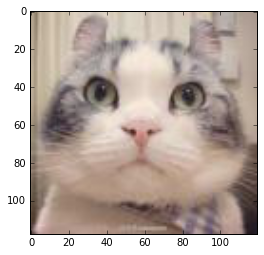

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline

image_raw_data = tf.gfile.FastGFile('D:/python_code/image/image2.jpg', 'rb').read()
with tf.Session() as sess:  
    img_data_jpg = tf.image.decode_jpeg(image_raw_data) #图像解码  
    img_data_jpg = tf.image.convert_image_dtype(img_data_jpg, dtype=tf.uint8) #改变图像数据的类型  
    plt.imshow(img_data_jpg.eval())
    plt.show()

[[[169 154 133]
  [180 165 144]
  [154 139 118]
  ..., 
  [169 152 142]
  [168 151 141]
  [167 150 140]]

 [[169 154 133]
  [180 165 144]
  [154 139 118]
  ..., 
  [169 152 142]
  [168 151 141]
  [167 150 140]]

 [[169 154 133]
  [181 166 145]
  [155 140 119]
  ..., 
  [170 153 143]
  [168 151 141]
  [167 150 140]]

 ..., 
 [[ 93  72  69]
  [124 103 100]
  [169 145 143]
  ..., 
  [ 34  27  35]
  [ 34  28  38]
  [ 30  27  36]]

 [[ 98  77  74]
  [120  99  96]
  [155 131 129]
  ..., 
  [ 32  25  33]
  [ 34  28  38]
  [ 30  27  36]]

 [[ 86  65  62]
  [ 94  73  70]
  [120  96  94]
  ..., 
  [ 32  25  33]
  [ 35  29  39]
  [ 31  28  37]]]
(1797, 2673, 3)


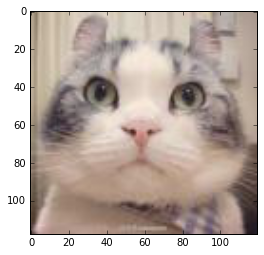

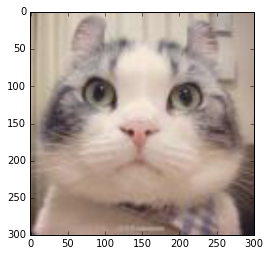

InvalidArgumentError: Expected begin[1] in [0, 118], but got 398
	 [[Node: Slice_6 = Slice[Index=DT_INT32, T=DT_UINT8, _device="/job:localhost/replica:0/task:0/cpu:0"](control_dependency_25, stack_18, stack_19)]]

Caused by op 'Slice_6', defined at:
  File "D:\anaconda1\lib\runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\anaconda1\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\anaconda1\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "D:\anaconda1\lib\site-packages\traitlets\config\application.py", line 596, in launch_instance
    app.start()
  File "D:\anaconda1\lib\site-packages\ipykernel\kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "D:\anaconda1\lib\site-packages\zmq\eventloop\ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "D:\anaconda1\lib\site-packages\tornado\ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "D:\anaconda1\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\anaconda1\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "D:\anaconda1\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\anaconda1\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "D:\anaconda1\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\anaconda1\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\anaconda1\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\anaconda1\lib\site-packages\ipykernel\kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "D:\anaconda1\lib\site-packages\ipykernel\ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\anaconda1\lib\site-packages\IPython\core\interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\anaconda1\lib\site-packages\IPython\core\interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\anaconda1\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-bf8a5efa7ac3>", line 36, in <module>
    croped = tf.image.resize_image_with_crop_or_pad(img_data, 1000, 1000)
  File "D:\anaconda1\lib\site-packages\tensorflow\python\ops\image_ops_impl.py", line 650, in resize_image_with_crop_or_pad
    min_(target_width, width))
  File "D:\anaconda1\lib\site-packages\tensorflow\python\ops\image_ops_impl.py", line 551, in crop_to_bounding_box
    array_ops.stack([-1, target_height, target_width, -1]))
  File "D:\anaconda1\lib\site-packages\tensorflow\python\ops\array_ops.py", line 545, in slice
    return gen_array_ops._slice(input_, begin, size, name=name)
  File "D:\anaconda1\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 2933, in _slice
    name=name)
  File "D:\anaconda1\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "D:\anaconda1\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "D:\anaconda1\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Expected begin[1] in [0, 118], but got 398
	 [[Node: Slice_6 = Slice[Index=DT_INT32, T=DT_UINT8, _device="/job:localhost/replica:0/task:0/cpu:0"](control_dependency_25, stack_18, stack_19)]]


In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline

# 1. 读取图片, [tensorflow-tutorial\Deep_Learning_with_TensorFlow\datasets\cat.jpg]
image_raw_data = tf.gfile.FastGFile("D:/python_code/image/image2.jpg", 'rb').read()

with tf.Session() as sess:
    img_data = tf.image.decode_jpeg(image_raw_data)

    # 输出解码之后的三维矩阵。
    print(img_data.eval())
    img_data.set_shape([1797, 2673, 3])
    print(img_data.get_shape())

# 2. 打印图片
with tf.Session() as sess:
    plt.imshow(img_data.eval())
    plt.show()

# 3. 重新调整图片大小
with tf.Session() as sess:
    resized = tf.image.resize_images(img_data, [300, 300], method=0)

    # TensorFlow的函数处理图片后存储的数据是float32格式的，需要转换成uint8才能正确打印图片。
    print
    "Digital type: ", resized.dtype
    cat = np.asarray(resized.eval(), dtype='uint8')
    # tf.image.convert_image_dtype(rgb_image, tf.float32)
    plt.imshow(cat)
    plt.show()

# 4. 裁剪和填充图片
with tf.Session() as sess:
    croped = tf.image.resize_image_with_crop_or_pad(img_data, 1000, 1000)
    padded = tf.image.resize_image_with_crop_or_pad(img_data, 3000, 3000)
    plt.imshow(croped.eval())
    plt.show()
    plt.imshow(padded.eval())
    plt.show()

# 5. 截取中间50%的图片
with tf.Session() as sess:
    central_cropped = tf.image.central_crop(img_data, 0.5)
    plt.imshow(central_cropped.eval())
    plt.show()

# 6. 翻转图片
with tf.Session() as sess:
    # 上下翻转
    # flipped1 = tf.image.flip_up_down(img_data)
    # 左右翻转
    # flipped2 = tf.image.flip_left_right(img_data)

    # 对角线翻转
    transposed = tf.image.transpose_image(img_data)
    plt.imshow(transposed.eval())
    plt.show()

    # 以一定概率上下翻转图片。
    # flipped = tf.image.random_flip_up_down(img_data)
    # 以一定概率左右翻转图片。
    # flipped = tf.image.random_flip_left_right(img_data)

# 7. 图片色彩调整
with tf.Session() as sess:
    # 将图片的亮度-0.5。
    # adjusted = tf.image.adjust_brightness(img_data, -0.5)

    # 将图片的亮度-0.5
    # adjusted = tf.image.adjust_brightness(img_data, 0.5)

    # 在[-max_delta, max_delta)的范围随机调整图片的亮度。
    adjusted = tf.image.random_brightness(img_data, max_delta=0.5)

    # 将图片的对比度-5
    # adjusted = tf.image.adjust_contrast(img_data, -5)

    # 将图片的对比度+5
    # adjusted = tf.image.adjust_contrast(img_data, 5)

    # 在[lower, upper]的范围随机调整图的对比度。
    # adjusted = tf.image.random_contrast(img_data, lower, upper)

    plt.imshow(adjusted.eval())
    plt.show()

# 8. 添加色相和饱和度
with tf.Session() as sess:
    adjusted = tf.image.adjust_hue(img_data, 0.1)
    # adjusted = tf.image.adjust_hue(img_data, 0.3)
    # adjusted = tf.image.adjust_hue(img_data, 0.6)
    # adjusted = tf.image.adjust_hue(img_data, 0.9)

    # 在[-max_delta, max_delta]的范围随机调整图片的色相。max_delta的取值在[0, 0.5]之间。
    # adjusted = tf.image.random_hue(image, max_delta)

    # 将图片的饱和度-5。
    # adjusted = tf.image.adjust_saturation(img_data, -5)
    # 将图片的饱和度+5。
    # adjusted = tf.image.adjust_saturation(img_data, 5)
    # 在[lower, upper]的范围随机调整图的饱和度。
    # adjusted = tf.image.random_saturation(img_data, lower, upper)

    # 将代表一张图片的三维矩阵中的数字均值变为0，方差变为1。
    # adjusted = tf.image.per_image_whitening(img_data)

    plt.imshow(adjusted.eval())
    plt.show()

# 9. 添加标注框并裁减
with tf.Session() as sess:
    boxes = tf.constant([[[0.05, 0.05, 0.9, 0.7], [0.35, 0.47, 0.5, 0.56]]])

    begin, size, bbox_for_draw = tf.image.sample_distorted_bounding_box(
        tf.shape(img_data), bounding_boxes=boxes)

    batched = tf.expand_dims(tf.image.convert_image_dtype(img_data, tf.float32), 0)
    image_with_box = tf.image.draw_bounding_boxes(batched, bbox_for_draw)

    distorted_image = tf.slice(img_data, begin, size)
    plt.imshow(distorted_image.eval())
    plt.show()

In [18]:
with tf.Session() as sess:
    print (croped)

Tensor("Squeeze_19:0", shape=(1000, 1000, 3), dtype=uint8)


In [ ]:
tf.image.crop_to_bounding_box(image, offset_height, offset_width, target_height, target_width)

图片指定的范围裁剪，保留指定范围内的数据。

该函数从image中裁剪出一个长方形的区域。长方形左上角在图片中的坐标为offset_height, offset_width
那么它的右下角在图片中的坐标为offset_height + target_height, offset_width + target_width。

参数:

image: 3维 [height, width, channels]tensor。
offset_height: 左上角坐标的高度值。
offset_width: 左上角坐标的宽度值。
target_height: 输出图片的高度。
target_width: 输出图片的宽度。
示例:

crop_to=tf.image.crop_to_bounding_box(image_decoded,100,100,400,400)

tf.image.pad_to_bounding_box(image, offset_height, offset_width, target_height, target_width)

扩展 image 到指定的 height 和width，扩展的部分填充0。
在图片的上部填充offset_height行0元素和在图片的左边填充offset_width列0元素后，将图片沿着下部行填充和右部列填充扩展至指定的高、宽。

参数:
image: 3维 [height, width, channels]tensor。
offset_height: 上部增加0元素的行数。
offset_width: 左部增加0元素的行数。
target_height: 输出图片的高度。
target_width: 输出图片的宽度。

示例：
pad_to=tf.image.pad_to_bounding_box(image_decoded,100,100,2000,2000)

In [ ]:
tf.image.draw_bounding_boxes(images, boxes, name=None)

给一批图片绘制方框。
每张图片绘制相同数量的方框，方框在图片中的坐标定义为 [y_min, x_min, y_max, x_max]，取值都在[0.0, 1.0]之间。

例如，一幅为100 x 200像素的图像，绘制的方框坐标为[0.1, 0.2, 0.5, 0.9], 那么它的左下角及右上角的像素点位置为 (10, 40) to (50, 180)。

参数:

images: 4维 [batch, height, width, depth]tensor。
boxes: 3维 [batch, num_bounding_boxes, 4] 包含需绘制的方框的信息。
示例:

#images中batch为3。
boxes=tf.Variable([[[0.1,0.2,0.5,0.9]],[[0.3,0.4,0.6,0.5]],[[0.5,0.6,0.7,0.8]]])
draw_bounding_boxes=tf.image.draw_bounding_boxes(images,boxes)

### 图像预处理完整样例

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 1. 随机调整图片的色彩，定义两种顺序
def distort_color(image, color_ordering=0):
    if color_ordering == 0:
        image = tf.image.random_brightness(image, max_delta=32./255.)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_hue(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    else:
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_brightness(image, max_delta=32./255.)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
        image = tf.image.random_hue(image, max_delta=0.2)

    return tf.clip_by_value(image, 0.0, 1.0)

# 2. 对图片进行预处理，将图片转化成神经网络的输入层数据
def preprocess_for_train(image, height, width, bbox):
    # 查看是否存在标注框。
    if bbox is None:
        bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
    if image.dtype != tf.float32:
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    # 随机的截取图片中一个块。
    bbox_begin, bbox_size, _ = tf.image.sample_distorted_bounding_box(
        tf.shape(image), bounding_boxes=bbox)
    bbox_begin, bbox_size, _ = tf.image.sample_distorted_bounding_box(
        tf.shape(image), bounding_boxes=bbox)
    distorted_image = tf.slice(image, bbox_begin, bbox_size)

    # 将随机截取的图片调整为神经网络输入层的大小。
    distorted_image = tf.image.resize_images(distorted_image, [height, width], method=np.random.randint(4))
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = distort_color(distorted_image, np.random.randint(2))
    return distorted_image

# 3. 读取图片
image_raw_data = tf.gfile.FastGFile("../../datasets/cat.jpg", "r").read()
with tf.Session() as sess:
    img_data = tf.image.decode_jpeg(image_raw_data)
    boxes = tf.constant([[[0.05, 0.05, 0.9, 0.7], [0.35, 0.47, 0.5, 0.56]]])
    for i in range(9):
        result = preprocess_for_train(img_data, 299, 299, boxes)
        plt.imshow(result.eval())
        plt.show()

tf.clip_by_value(A, min, max)：
输入一个张量A，把A中的每一个元素的值都压缩在min和max之间。小于min的让它等于min，大于max的元素的值等于max。

In [27]:
import tensorflow as tf  
import numpy as np  
x=[[1,2,3],[4,5,6]]  
y=np.arange(24).reshape([2,3,4])  
z=tf.constant([[[1,2,3],[4,5,6]], [[7,8,9],[10,11,12]],  [[13,14,15],[16,17,18]]])
print (y)

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]


### 队列操作

In [29]:
import tensorflow as tf

# 1. 创建队列，并操作里面的元素
q = tf.FIFOQueue(2, "int32")
init = q.enqueue_many(([0, 10],))
x = q.dequeue()
y = x + 1
q_inc = q.enqueue([y])
with tf.Session() as sess:
    init.run()
    for _ in range(6):
        v, _ = sess.run([x, q_inc])
        print(v)
'''
0
10
1
11
2
'''

0
10
1
11
2
12


'\n0\n10\n1\n11\n2\n'

In [33]:
print (q.dequeue())

Tensor("fifo_queue_1_Dequeue_1:0", dtype=int32)


In [9]:
# 2. 这个程序每隔1秒判断是否需要停止并打印自己的ID
import numpy as np
import threading
import time
def MyLoop(coord, worker_id):
    while not coord.should_stop():
        if np.random.rand()<0.1:
            print("Stoping from id: %d\n" % worker_id, coord.request_stop())
        else:
            print("Working on id: %d\n" % worker_id, time.sleep(1))

# 3. 创建、启动并退出线程
coord = tf.train.Coordinator()
threads = [threading.Thread(target=MyLoop, args=(coord, i, )) for i in range(5)]
for t in threads:t.start()
coord.join(threads)
'''
Stoping from id: 1
 None
Working on id: 0
 None
'''

Working on id: 0
 None
Working on id: 3
 None
Working on id: 2
 None
Stoping from id: 2
 None
Working on id: 1
 None
Working on id: 4
 None
Working on id: 0
Working on id: 3
 None
 None


'\nStoping from id: 1\n None\nWorking on id: 0\n None\n'

should_stop():如果线程应该停止则返回True。
request_stop(<exception>): 请求该线程停止。
join(<list of threads>):等待被指定的线程终止。

### 多线程队列操作

In [1]:
import tensorflow as tf
# 1. 定义队列及其操作
queue = tf.FIFOQueue(100,"float")
enqueue_op = queue.enqueue([tf.random_normal([1])])
qr = tf.train.QueueRunner(queue, [enqueue_op] * 5)  
#创建一个QueueRunner来运行几个线程， 这几个线程处理样本，并且将样本推入队列。
#创建一个Coordinator，让queue runner使用Coordinator来启动这些线程，创建一个训练的循环， 
#并且使用Coordinator来控制QueueRunner的线程们的终止。
tf.train.add_queue_runner(qr)
#通过调用方法tf.train.add_queue_runner，对应每个队列的tf.train.QueueRunner将会被将入到graph中。
#每一个QueueRunner负责管理每一个队列。一旦graph搭建完成，
#tf.train.start_queue_runners将会使得每一个在graph中的QueueRunner如开启自己的threads去运行队列操作。
out_tensor = queue.dequeue()

# 2. 启动线程
with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    for _ in range(3):
        print(sess.run(out_tensor)[0])
    coord.request_stop()
    coord.join(threads)


0.456552
-1.07787
0.232182


QueueRunner
QueueRunner类会创建一组线程， 这些线程可以重复的执行Enquene操作， 他们使用同一个Coordinator来处理线程同步终止。此外，一个QueueRunner会运行一个closer thread，当Coordinator收到异常报告时，这个closer thread会自动关闭队列。

### 输入文件队列

In [ ]:
import tensorflow as tf

# 1. 生成文件存储样例数据
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
num_shards = 2
instances_per_shard = 2
for i in range(num_shards):
    filename = ('Records/data.tfrecords-%.5d-of-%.5d' % (i, num_shards))
    # 将Example结构写入TFRecord文件。
    writer = tf.python_io.TFRecordWriter(filename)
    for j in range(instances_per_shard):
    # Example结构仅包含当前样例属于第几个文件以及是当前文件的第几个样本。
        example = tf.train.Example(features=tf.train.Features(feature={
            'i': _int64_feature(i),
            'j': _int64_feature(j)}))
        writer.write(example.SerializeToString())
    writer.close()

# 2. 读取文件
files = tf.train.match_filenames_once("Records/data.tfrecords-*")
filename_queue = tf.train.string_input_producer(files, shuffle=False)
reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)
features = tf.parse_single_example(
      serialized_example,
      features={
          'i': tf.FixedLenFeature([], tf.int64),
          'j': tf.FixedLenFeature([], tf.int64),
      })
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    print(sess.run(files))
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    for i in range(6):
        print(sess.run([features['i'], features['j']]))
    coord.request_stop()
    coord.join(threads)
'''
[b'Records\\data.tfrecords-00000-of-00002'
 b'Records\\data.tfrecords-00001-of-00002']
[0, 0]
[0, 1]
[1, 0]
[1, 1]
[0, 0]
[0, 1]
'''
# 3. 组合训练数据（Batching）
example, label = features['i'], features['j']
batch_size = 2
capacity = 1000 + 3 * batch_size
capacity = 1000 + 3 * batch_size
example_batch, label_batch = tf.train.batch([example, label], batch_size=batch_size, capacity=capacity)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    for i in range(3):
        cur_example_batch, cur_label_batch = sess.run([example_batch, label_batch])
        print(cur_example_batch, cur_label_batch)
    coord.request_stop()
    coord.join(threads)
'''
[0 0] [0 1]
[1 1] [0 1]
[0 0] [0 1]
'''

### 输入数据处理框架

In [ ]:
import tensorflow as tf

# 1. 创建文件列表，通过文件列表创建输入文件队列，读取文件为本章第一节创建的文件
files = tf.train.match_filenames_once("Records/output.tfrecords")
filename_queue = tf.train.string_input_producer(files, shuffle=False)

# 2. 解析TFRecord文件里的数据
# 读取文件。
reader = tf.TFRecordReader()
_,serialized_example = reader.read(filename_queue)

# 3. 解析读取的样例。
features = tf.parse_single_example(
    serialized_example,
    features={
        'image_raw':tf.FixedLenFeature([],tf.string),
        'pixels':tf.FixedLenFeature([],tf.int64),
        'label':tf.FixedLenFeature([],tf.int64)
    })

decoded_images = tf.decode_raw(features['image_raw'],tf.uint8)
retyped_images = tf.cast(decoded_images, tf.float32)
labels = tf.cast(features['label'],tf.int32)
#pixels = tf.cast(features['pixels'],tf.int32)
images = tf.reshape(retyped_images, [784])

# 4. 将文件以100个为一组打包
min_after_dequeue = 10000
batch_size = 100
capacity = min_after_dequeue + 3 * batch_size

image_batch, label_batch = tf.train.shuffle_batch([images, labels],
                                                    batch_size=batch_size,
                                                    capacity=capacity,
                                                    min_after_dequeue=min_after_dequeue)

# 5. 训练模型
def inference(input_tensor, weights1, biases1, weights2, biases2):
    layer1 = tf.nn.relu(tf.matmul(input_tensor, weights1) + biases1)
    return tf.matmul(layer1, weights2) + biases2

# 模型相关的参数
INPUT_NODE = 784
OUTPUT_NODE = 10
LAYER1_NODE = 500
REGULARAZTION_RATE = 0.0001
TRAINING_STEPS = 5000

weights1 = tf.Variable(tf.truncated_normal([INPUT_NODE, LAYER1_NODE], stddev=0.1))
biases1 = tf.Variable(tf.constant(0.1, shape=[LAYER1_NODE]))

weights2 = tf.Variable(tf.truncated_normal([LAYER1_NODE, OUTPUT_NODE], stddev=0.1))
biases2 = tf.Variable(tf.constant(0.1, shape=[OUTPUT_NODE]))

y = inference(image_batch, weights1, biases1, weights2, biases2)

# 计算交叉熵及其平均值
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y, labels=label_batch)
cross_entropy_mean = tf.reduce_mean(cross_entropy)

# 损失函数的计算
regularizer = tf.contrib.layers.l2_regularizer(REGULARAZTION_RATE)
regularaztion = regularizer(weights1) + regularizer(weights2)
loss = cross_entropy_mean + regularaztion

# 优化损失函数
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

# 初始化回话并开始训练过程。
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    # 循环的训练神经网络。
    for i in range(TRAINING_STEPS):
        if i % 1000 == 0:
            print("After %d training step(s), loss is %g " % (i, sess.run(loss)))

        sess.run(train_step)
    coord.request_stop()
    coord.join(threads)


### SKlearn封装例子 code 

In [1]:
from sklearn import model_selection
from sklearn import datasets
from sklearn import metrics
import tensorflow as tf
import numpy as np
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat
learn = tf.contrib.learn

# 1. 自定义softmax回归模型
def my_model(features, target):
    target = tf.one_hot(target, 3, 1, 0)

    # 计算预测值及损失函数。
    logits = tf.contrib.layers.fully_connected(features, 3, tf.nn.softmax)
    loss = tf.losses.softmax_cross_entropy(target, logits)

    # 创建优化步骤。
    train_op = tf.contrib.layers.optimize_loss(
        loss,
        tf.contrib.framework.get_global_step(),
        optimizer='Adam',
        learning_rate=0.01)
    return tf.arg_max(logits, 1), loss, train_op

# 2. 读取数据并将数据转化成TensorFlow要求的float32格式
iris = datasets.load_iris()
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    iris.data, iris.target, test_size=0.2, random_state=0)

x_train, x_test = map(np.float32, [x_train, x_test])

# 3. 封装和训练模型，输出准确率
classifier = SKCompat(learn.Estimator(model_fn=my_model, model_dir="Models/model_1"))
classifier.fit(x_train, y_train, steps=800)

y_predicted = [i for i in classifier.predict(x_test)]
score = metrics.accuracy_score(y_test, y_predicted)
print('Accuracy: %.2f%%' % (score * 100))
'''
Accuracy: 100.00%
'''

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': None, '_keep_checkpoint_max': 5, '_is_chief': True, '_model_dir': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_master': '', '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_environment': 'local', '_num_ps_replicas': 0, '_save_summary_steps': 100, '_task_id': 0, '_num_worker_replicas': 0, '_evaluation_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001FA47261080>, '_task_type': None}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into Models/model_1\model.ckpt.
INFO:tensorflow:loss = 1.05083, step = 1
INFO:tensorflow:global_step/sec: 929.725
INFO:tensorflow:loss = 0.768423, step = 101 (0.109 sec)
INFO:tensorflow:global_step/sec: 1017.6
INFO:tensorflow:loss = 0.699499, step = 201 (0.098 sec)
INFO:tensorflow:global_step/sec: 1126

'\nAccuracy: 100.00%\n'

### Tensorboard 可视化

In [2]:

import tensorflow as tf;

# 定义一个简单的计算图，实现向量加法操作
input1 = tf.constant([1.0, 2.0, 3.0], name="input1");
input2 = tf.Variable(tf.random_uniform([3], name="input2"));
output = tf.add_n([input1, input2], name="add");

# 生产一个写日志的writer，并将当前的TensorFlow计算图写入日志，TensorFlow提供了多种写日志的API
writer = tf.summary.FileWriter("D:/python_code/tensorBoard/tensorlog/logs", tf.get_default_graph())
writer.close()

In [1]:
import tensorflow as tf

# 1. 不同的命名空间
with tf.variable_scope("foo"):
    a = tf.get_variable("bar", [1])
    print(a.name)
with tf.variable_scope("bar"):
    b = tf.get_variable("bar", [1])
    print(b.name)
'''
foo/bar:0
bar/bar:0
'''
# 2. tf.Variable和tf.get_variable的区别
with tf.name_scope("a"):
    a = tf.Variable([1])
    print(a.name)
    a = tf.get_variable("b", [1])
    print(a.name)
'''
a/Variable:0
b:0
'''

# 3. TensorBoard可以根据命名空间来整理可视化效果图上的节点
with tf.name_scope("input1"):
    input1 = tf.constant([1.0, 2.0, 3.0], name="input2")
with tf.name_scope("input2"):
    input2 = tf.Variable(tf.random_uniform([3]), name="input2")
output = tf.add_n([input1, input2], name="add")

# tensorboard --port=6006 --debug --logdir=c:/python35/tensorlog/show02
writer = tf.summary.FileWriter("D:/python_code/tensorBoard/tensorlog/show02", tf.get_default_graph())
writer.close()

foo/bar:0
bar/bar:0
a/Variable:0
b:0


### 分布式tensorflow code

In [ ]:
import tensorflow as tf

# 创建一个本地集群。
c = tf.constant("Hello, distributed TensorFlow!")
server = tf.train.Server.create_local_server()
sess = tf.Session(server.target)
print(sess.run(c))

# 创建两个集群
c = tf.constant("Hello from server1!")
cluster = tf.train.ClusterSpec({"local": ["localhost:2222", "localhost:2223"]})
server = tf.train.Server(cluster, job_name="local", task_index=0)
sess = tf.Session(server.target, config=tf.ConfigProto(log_device_placement=True))
print(sess.run(c))
server.join()

import tensorflow as tf
c = tf.constant("Hello from server2!")
cluster = tf.train.ClusterSpec({"local": ["localhost:2222", "localhost:2223"]})
server = tf.train.Server(cluster, job_name="local", task_index=1)
sess = tf.Session(server.target, config=tf.ConfigProto(log_device_placement=True))
print(sess.run(c))
server.join()

b'Hello, distributed TensorFlow!'


In [ ]:
#异步更新
import time
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import mnist_inference

# 配置神经网络的参数。
BATCH_SIZE = 100
LEARNING_RATE_BASE = 0.01
LEARNING_RATE_DECAY = 0.99
REGULARAZTION_RATE = 0.0001
TRAINING_STEPS = 1000
MOVING_AVERAGE_DECAY = 0.99

# 模型保存的路径和文件名。
MODEL_SAVE_PATH = "logs/log_async"
DATA_PATH = "../../datasets/MNIST_data"

FLAGS = tf.app.flags.FLAGS

# 指定当前程序是参数服务器还是计算服务器。
tf.app.flags.DEFINE_string('job_name', 'worker', ' "ps" or "worker" ')
# 指定集群中的参数服务器地址。
tf.app.flags.DEFINE_string(
    'ps_hosts', ' tf-ps0:2222,tf-ps1:1111',
    'Comma-separated list of hostname:port for the parameter server jobs. e.g. "tf-ps0:2222,tf-ps1:1111" ')
# 指定集群中的计算服务器地址。
tf.app.flags.DEFINE_string(
    'worker_hosts', ' tf-worker0:2222,tf-worker1:1111',
    'Comma-separated list of hostname:port for the worker jobs. e.g. "tf-worker0:2222,tf-worker1:1111" ')
# 指定当前程序的任务ID。
tf.app.flags.DEFINE_integer('task_id', 0, 'Task ID of the worker/replica running the training.')

# 定义TensorFlow的计算图，并返回每一轮迭代时需要运行的操作。
def build_model(x, y_, is_chief):
    regularizer = tf.contrib.layers.l2_regularizer(REGULARAZTION_RATE)
    # 通过和5.5节给出的mnist_inference.py代码计算神经网络前向传播的结果。
    y = mnist_inference.inference(x, regularizer)
    global_step = tf.Variable(0, trainable=False)

    # 计算损失函数并定义反向传播过程。
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y, labels=tf.argmax(y_, 1))
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
    loss = cross_entropy_mean + tf.add_n(tf.get_collection('losses'))
    learning_rate = tf.train.exponential_decay(
        LEARNING_RATE_BASE, global_step, 60000 / BATCH_SIZE, LEARNING_RATE_DECAY)
    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # 定义每一轮迭代需要运行的操作。
    if is_chief:
        # 计算变量的滑动平均值。
        variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, global_step)
        variables_averages_op = variable_averages.apply(tf.trainable_variables())
        with tf.control_dependencies([variables_averages_op, train_op]):
            train_op = tf.no_op()
    return global_step, loss, train_op


def main(argv=None):
    # 解析flags并通过tf.train.ClusterSpec配置TensorFlow集群。
    ps_hosts = FLAGS.ps_hosts.split(',')
    worker_hosts = FLAGS.worker_hosts.split(',')
    cluster = tf.train.ClusterSpec({"ps": ps_hosts, "worker": worker_hosts})
    # 通过tf.train.ClusterSpec以及当前任务创建tf.train.Server。
    server = tf.train.Server(cluster, job_name = FLAGS.job_name, task_index=FLAGS.task_id)

    # 参数服务器只需要管理TensorFlow中的变量，不需要执行训练的过程。server.join()会
    # 一致停在这条语句上。
    if FLAGS.job_name == 'ps':
        with tf.device("/cpu:0"):
            server.join()

    # 定义计算服务器需要运行的操作。
    is_chief = (FLAGS.task_id == 0)
    mnist = input_data.read_data_sets(DATA_PATH, one_hot=True)

    device_setter = tf.train.replica_device_setter(worker_device="/job:worker/task:%d" % FLAGS.task_id, cluster=cluster)
    with tf.device(device_setter):

        # 定义输入并得到每一轮迭代需要运行的操作。
        x = tf.placeholder(tf.float32, [None, mnist_inference.INPUT_NODE], name='x-input')
        y_ = tf.placeholder(tf.float32, [None, mnist_inference.OUTPUT_NODE], name='y-input')
        global_step, loss, train_op = build_model(x, y_, is_chief)

        # 定义用于保存模型的saver。
        saver = tf.train.Saver()
        # 定义日志输出操作。
        summary_op = tf.summary.merge_all()
        # 定义变量初始化操作。
        init_op = tf.global_variables_initializer()
        # 通过tf.train.Supervisor管理训练深度学习模型时的通用功能。
        sv = tf.train.Supervisor(
            is_chief=is_chief,
            logdir=MODEL_SAVE_PATH,
            init_op=init_op,
            summary_op=summary_op,
            saver=saver,
            global_step=global_step,
            save_model_secs=60,
            save_summaries_secs=60)

        sess_config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
        # 通过tf.train.Supervisor生成会话。
        sess = sv.prepare_or_wait_for_session(server.target, config=sess_config)

        step = 0
        start_time = time.time()

        # 执行迭代过程。
        while not sv.should_stop():
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            _, loss_value, global_step_value = sess.run([train_op, loss, global_step], feed_dict={x: xs, y_: ys})
            if global_step_value >= TRAINING_STEPS: break

           # 每隔一段时间输出训练信息。
            if step > 0 and step % 100 == 0:
                duration = time.time() - start_time
                sec_per_batch = duration / global_step_value
                format_str = "After %d training steps (%d global steps), loss on training batch is %g.  (%.3f sec/batch)"
                print(format_str % (step, global_step_value, loss_value, sec_per_batch))
            step += 1
    sv.stop()

if __name__ == "__main__":
    tf.app.run()

### tensorflow debugger

import argparse
parse = argparse.ArgumentParser()
parse.add_argument("a", help="params means")
parse.add_argument("-C", "--gc", default="count")
parse.add_argument("--ga", help="params means ga",dest='simple_value',choices=['A', 'B', 'C', 0])
parse.add_argument("--gb", help="params means gb",action="store_const",const='value-to-store')
args = parse.parse_args()
print args.simple_value,args.gb,args.gc

### add_argument 说明
不带'--'的参数
    调用脚本时必须输入值
    参数输入的顺序与程序中定义的顺序一致
'-'的参数
    可不输入    add_argument("-a")
    类似有'--'的shortname，但程序中的变量名为定义的参数名
'--'参数
    参数别名: 只能是1个字符，区分大小写
        add_argument("-shortname","--name", help="params means")，但代码中不能使用shortname
    dest: 参数在程序中对应的变量名称 add_argument("a",dest='code_name')
    default: 参数默认值
    help: 参数作用解释  add_argument("a", help="params means")
    type : 默认string  add_argument("c", type=int)
    action:
    store：默认action模式，存储值到指定变量。
    store_const：存储值在参数的const部分指定，多用于实现非布尔的命令行flag。
    store_true / store_false：布尔开关。 store_true.默认为False，输入则为true。 store_flase 相反
    append：存储值到列表，该参数可以重复使用。
    append_const：存储值到列表，存储值在参数的const部分指定。
    count: 统计参数简写输入的个数  add_argument("-c", "--gc", action="count")
    version 输出版本信息然后退出。
    const:配合action="store_const|append_const"使用，默认值
    choices:输入值的范围 add_argument("--gb", choices=['A', 'B', 'C', 0])
    required : 默认False, 若为 True, 表示必须输入该参数

### 实际执行具体的训练，测试及日志记录的操作  
""" 
首先，使用tf.train.Saver()创建模型的保存器。 
然后，进入训练的循环中，每隔10步执行一次merged（数据汇总），accuracy（求测试集上的预测准确率）操作， 
并使应test_write.add_summary将汇总结果summary和循环步数i写入日志文件; 
同时每隔100步，使用tf.RunOption定义Tensorflow运行选项，其中设置trace_level为FULL——TRACE, 
并使用tf.RunMetadata()定义Tensorflow运行的元信息， 
这样可以记录训练是运算时间和内存占用等方面的信息. 
再执行merged数据汇总操作和train_step训练操作，将汇总summary和训练元信息run_metadata添加到train_writer. 
平时，则执行merged操作和train_step操作，并添加summary到trian_writer。 
所有训练全部结束后，关闭train_writer和test_writer。 

In [ ]:
for i in range(FLAGS.max_steps):
        if i % 10 == 0:  # Record summaries and test-set accuracy
            summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict(False))
            test_writer.add_summary(summary, i)
            print('Accuracy at step %s: %s' % (i, acc))
        else:  # Record train set summaries, and train
            if i % 100 == 99:  # Record execution stats
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
                summary, _ = sess.run([merged, train_step],
                                      feed_dict=feed_dict(True),
                                      options=run_options,
                                      run_metadata=run_metadata)
                train_writer.add_run_metadata(run_metadata, 'step%03d' % i)
                train_writer.add_summary(summary, i)
                print('Adding run metadata for', i)
            else:  # Record a summary
                summary, _ = sess.run([merged, train_step], feed_dict=feed_dict(True))
                train_writer.add_summary(summary, i)
    train_writer.close()
    test_writer.close()


def main(_):
    if tf.gfile.Exists(FLAGS.log_dir):
        tf.gfile.DeleteRecursively(FLAGS.log_dir)
    tf.gfile.MakeDirs(FLAGS.log_dir)
    train()


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--fake_data', nargs='?', const=True, type=bool,
                        default=False,
                        help='If true, uses fake data for unit testing.')
    parser.add_argument('--max_steps', type=int, default=1000,
                        help='Number of steps to run trainer.')
    parser.add_argument('--learning_rate', type=float, default=0.001,
                        help='Initial learning rate')
    parser.add_argument('--dropout', type=float, default=0.9,
                        help='Keep probability for training dropout.')
    parser.add_argument(
        '--data_dir',
        type=str,
        default='/tmp/tensorflow/mnist/input_data',
        help='Directory for storing input data')
    parser.add_argument(
        '--log_dir',
        type=str,
        default='/tmp/tensorflow/mnist/logs/mnist_with_summaries',
        help='Summaries log directory')
    FLAGS, unparsed = parser.parse_known_args()
    tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)
